In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from ISLP import load_data
from sklearn.model_selection import (train_test_split,cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from functools import partial
import patsy



In [178]:
# validation set approach
auto = load_data('Auto')
train, test = train_test_split(auto, test_size=0.5, random_state=42)
train_x= train.drop(columns=['mpg'])
train_y= train['mpg']
test_x= test.drop(columns=['mpg'])
test_y= test['mpg']
linear_model = smf.ols(formula='mpg ~ horsepower', data=train).fit()
predictions = linear_model.predict(test_x)
# Calculate the residuals
residuals = test_y - predictions
# Calculate the mean squared error
mse = np.mean(residuals**2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 25.5738781896844


In [179]:
def evaluate_model(trainset, testset):
    formulas = [
        'mpg ~ horsepower',                # Linear
        'mpg ~ horsepower + I(horsepower**2)',  # Quadratic
        'mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)'  # Cubic
    ]
    # i iterates through the formulas, enumerate takes the formulas and the second argument is the starting index, it could be any number
    # formula takes the first value of the list 
    for i, formula in enumerate(formulas, 1):
        # Fit the model on the training set
        model = smf.ols(formula=formula, data=trainset).fit()
        
        # Predictions for training and test sets
        train_predictions = model.predict(trainset)
        test_predictions = model.predict(testset)
        
        # Calculate MSE for training and test sets
        train_mse = np.mean((trainset['mpg'] - train_predictions)**2)
        test_mse = np.mean((testset['mpg'] - test_predictions)**2)
        
        # Print results
        print(f"Degree {i}:")
        print(f"  Training MSE: {train_mse:.2f}")
        print(f"  Test MSE: {test_mse:.2f}")
        print("-" * 30)

In [184]:
train,test = train_test_split(auto, test_size=0.5, random_state=42)
evaluate_model(train, test)

Degree 1:
  Training MSE: 23.16
  Test MSE: 25.57
------------------------------
Degree 2:
  Training MSE: 16.84
  Test MSE: 22.22
------------------------------
Degree 3:
  Training MSE: 16.59
  Test MSE: 22.67
------------------------------


In [181]:
train,test = train_test_split(auto, test_size=0.3, random_state=42)
evaluate_model(train, test)

Degree 1:
  Training MSE: 23.93
  Test MSE: 24.56
------------------------------
Degree 2:
  Training MSE: 18.59
  Test MSE: 20.45
------------------------------
Degree 3:
  Training MSE: 18.49
  Test MSE: 20.59
------------------------------


mpg~I(horsepower**1)
Mean MSE of degree1: 24.14
mpg~I(horsepower**1)+I(horsepower**2)
Mean MSE of degree2: 19.29
mpg~I(horsepower**1)+I(horsepower**2)+I(horsepower**3)
Mean MSE of degree3: 19.49
mpg~I(horsepower**1)+I(horsepower**2)+I(horsepower**3)+I(horsepower**4)
Mean MSE of degree4: 19.57
mpg~I(horsepower**1)+I(horsepower**2)+I(horsepower**3)+I(horsepower**4)+I(horsepower**5)
Mean MSE of degree5: 18.98


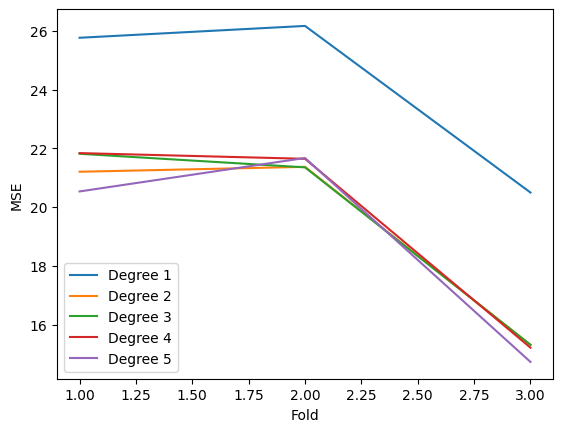

In [182]:
auto = load_data('Auto')
auto.index
auto.reset_index(drop=True, inplace=True)
auto.index

# cross-validation from scratch
def cross_validate_model(data, n_splits,degree):
    length = len(data)
    rng = np.random.default_rng(42)
    numbers= rng.permutation(length)
    num_in_each_split = length // n_splits
    # fit the model
    for i in range(1, degree + 1):
        formula = 'mpg~'+'+'.join([f'I(horsepower**{j})' for j in range(1, i+1)])
        print(formula)
        A=[]
        for k in range(0,n_splits):
            start = k*num_in_each_split
            if k == n_splits - 1:
                # Last split may contain more data if length is not divisible by n_splits
                end = length
            else:
                end= (k + 1) * num_in_each_split
            # Create the test set
            test_indices = numbers[start:end]
            test_set = data.iloc[test_indices]
            # Create the training set
            # either give row or column in drop it does not take index 
            # train_set = data.drop(test_set.index, axis=0)
            train_set = auto.drop(test_indices, axis=0)
            model = smf.ols(formula=formula , data=train_set).fit()
            # Predictions for training and test sets
            test_predictions = model.predict(test_set)
            mse = np.mean((test_set['mpg'] - test_predictions)**2)
            A.append(mse)
            
        
        print(f"Mean MSE of degree{i}: {np.mean(A):.2f}")
        sns.lineplot(x=range(1,k+2), y=A, label=f'Degree {i}')
        plt.xlabel('Fold')
        plt.ylabel('MSE')
plt.show()
        
cross_validate_model(auto, 3,5)





In [183]:


# Define the formula for the model
formula = 'mpg ~ horsepower + I(horsepower**2)'

# Number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store MSE for each fold
mse_list = []

# Perform cross-validation
for train_index, test_index in kf.split(auto):
    # Split the data into training and validation sets
    train_data = auto.iloc[train_index]
    test_data = auto.iloc[test_index]
    
    # Fit the model on the training set
    model = smf.ols(formula=formula, data=train_data).fit()
    
    # Predict on the validation set
    predictions = model.predict(test_data)
    
    # Calculate MSE for the validation set
    mse = np.mean((test_data['mpg'] - predictions)**2)
    mse_list.append(mse)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_list)

# Print the results
print("MSE for each fold:", mse_list)
print("Average MSE:", average_mse)

MSE for each fold: [18.416967796015197, 24.48824394944499, 19.93815624393849, 13.200412541347623, 20.064777768395686]
Average MSE: 19.221711659828394
